# Sentiment Analysis On Amazon Reviews

In [1]:
import pandas as pd
from nltk.tokenize import word_tokenize,RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from nltk import FreqDist
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report
from nltk.util import ngrams
from sklearn.model_selection import train_test_split

In [2]:
data=pd.read_csv('reviews.csv',sep='\t')

In [3]:
data.drop('Unnamed: 0',axis=1,inplace=True)

###### Splitting data into train and test dataset

In [4]:
train_x,test_x,train_y,test_y=train_test_split(data.iloc[:,0:6],data['Positively Rated'],test_size=0.20)

In [5]:
data.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Positively Rated
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0,1
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0,1
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0,1
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0,1
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 308277 entries, 0 to 308276
Data columns (total 7 columns):
Product Name        308277 non-null object
Brand Name          308277 non-null object
Price               308277 non-null float64
Rating              308277 non-null int64
Reviews             308277 non-null object
Review Votes        308277 non-null float64
Positively Rated    308277 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 16.5+ MB


In [7]:
data.describe(include=['object'])

,Product Name,Brand Name,Reviews
count,308277,308277,308277
unique,3645,376,128282
top,"BLU Studio 5.0 C HD Unlocked Cellphone, Black",Samsung,Good
freq,1045,58857,2209


In [8]:
data.describe()

,Price,Rating,Review Votes,Positively Rated
count,308277.000000,308277.000000,308277.000000,308277.000000
mean,226.059362,3.894614,1.490072,0.748269
std,285.064731,1.585468,9.252592,0.434008
min,1.730000,1.000000,0.000000,0.000000
25%,77.990000,2.000000,0.000000,0.000000
50%,139.040000,5.000000,0.000000,1.000000
75%,269.100000,5.000000,1.000000,1.000000
max,2598.000000,5.000000,645.000000,1.000000


###### Tokenization 

In [9]:
reg=RegexpTokenizer(r'[a-z0-9]+')

In [10]:
all_words=[]
lemmatizer = WordNetLemmatizer()
stop_words=stopwords.words('english')
for symb in string.punctuation:
    stop_words.append(symb)
for sent in train_x['Reviews'].str.lower():
    for word in reg.tokenize(sent):
        if word not in stop_words:
            word=lemmatizer.lemmatize(word)
            all_words.append(word)


Finding frequency for each word

In [11]:
dist=FreqDist(all_words)

In [34]:
dist.most_common(10)

[('phone', 284337),
 ('great', 64422),
 ('good', 59651),
 ('work', 53327),
 ('one', 40711),
 ('like', 36696),
 ('screen', 35606),
 ('use', 33496),
 ('love', 33456),
 ('battery', 33222)]

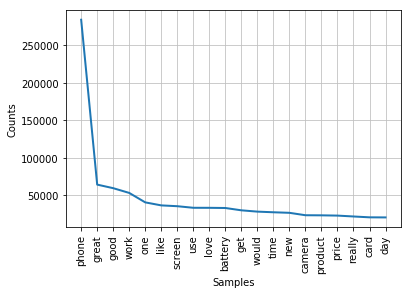

In [13]:
dist.plot(20)

Sometimes,the combination of two words also conveys a particular meaning . So,we are creating bigrams.

In [14]:
n_grams=[]
words=[]
for sent in train_x['Reviews'].str.lower():
    for word in reg.tokenize(sent):
        if word not in stop_words:
            words.append(lemmatizer.lemmatize(word))
for tup in ngrams(words,2):
        n_grams.append(tup)
n_grams_dist=FreqDist(n_grams)

Creating new features from given reviews

In [15]:
vocab=[]
for tup in dist.most_common()[:2000]:
    vocab.append(tup[0])
for tup in n_grams_dist.most_common()[:200]:
    vocab.append(tup[0])

Explicit Tokenizer for CountVectorizer

In [16]:
def token(sent):
    words=[]
    for word in reg.tokenize(sent):
        words.append(lemmatizer.lemmatize(word))
    return words

In [17]:
vect=CountVectorizer(tokenizer=token,vocabulary=vocab,ngram_range=(1,2))

Constructing a matrix to calculate the frequency of each word for all reviews.

In [18]:
dtm=vect.fit_transform(train_x['Reviews'].str.lower()).toarray()

In [19]:
col=vect.get_feature_names()

In [20]:
trainingset=pd.DataFrame(dtm,columns=col)

##### Model Creation Using GaussianNB Classifier

In [21]:
gnb=GaussianNB()

In [22]:
gnb.fit(trainingset,train_y)

GaussianNB(priors=None)

In [23]:
predicted=gnb.predict(trainingset)
accuracy_score(train_y,predicted)

0.8413476549036781

In [24]:
print(classification_report(train_y,predicted))

             precision    recall  f1-score   support

          0       0.70      0.64      0.67     62096
          1       0.88      0.91      0.90    184525

avg / total       0.84      0.84      0.84    246621



Prediction on test data to check the accuracy of model. Checking on test data also ensures that our model is not
overfitted

In [25]:
dtm=vect.fit_transform(test_x['Reviews'].str.lower()).toarray()
col=vect.get_feature_names()
testingset=pd.DataFrame(dtm,columns=col)
predicted=gnb.predict(testingset)
print('accuracy on test data',accuracy_score(test_y,predicted))
print(classification_report(test_y,predicted))

accuracy on test data 0.8353282729985727
             precision    recall  f1-score   support

          0       0.69      0.63      0.66     15507
          1       0.88      0.90      0.89     46149

avg / total       0.83      0.84      0.83     61656



TfidfVectorizer is used to minimize the effect of words appering in almost all the reviews

In [26]:
vect_tf=TfidfVectorizer(tokenizer=token,vocabulary=vocab,ngram_range=(1,2))
dtm_of_tf=vect_tf.fit_transform(train_x['Reviews'].str.lower()).toarray()
col_of_tf=vect_tf.get_feature_names()
trainingset_tf=pd.DataFrame(dtm_of_tf,columns=col)

In [29]:
gnb_tf=gnb.fit(trainingset,train_y)
predicted_tf=gnb_tf.predict(testingset)
accuracy_score(test_y,predicted_tf)
print(classification_report(test_y,predicted_tf))

             precision    recall  f1-score   support

          0       0.69      0.63      0.66     15507
          1       0.88      0.90      0.89     46149

avg / total       0.83      0.84      0.83     61656



##### Model Creation Using LogisticRegression Classifier

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
lr=LogisticRegression()

In [32]:
lr.fit(trainingset,train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
predicted=lr.predict(testingset)
print('accuracy on test data',accuracy_score(test_y,predicted))
print(classification_report(test_y,predicted))

accuracy on test data 0.9217270014272739
             precision    recall  f1-score   support

          0       0.89      0.79      0.84     15507
          1       0.93      0.97      0.95     46149

avg / total       0.92      0.92      0.92     61656



#### Hence, the accuracy is 92.2% and f1-score is 0.92 